In [21]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from prophet import Prophet

from utils import get_the_hourly_data, get_the_daily_data


In [22]:
def evaluate_prophet(df, start_date_test, prediction):
    time = pd.DataFrame({
    'date':pd.date_range(start=start_date_test, periods=30)
    })
    ytrue = df['temperature_air_mean_200']
    time['ytrue'] = ytrue.tolist()
    yhat = prediction['yhat'].iloc[len(prediction) - 30 : ]
    time['yhat'] = yhat.tolist()
    time.set_index('date', inplace = True)
    plt.plot(time.index, time['yhat'])
    plt.plot(time.index, time['ytrue'])
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Temperature (C)')
    plt.legend(('Prediction', 'Actual'))

    return time

In [54]:
start_date= "2018-01-01"
end_date= "2020-11-30"
df = get_the_daily_data(start_date, end_date)

INFO:wetterdienst.core.scalar.request:Processing request DwdObservationRequest(parameter=[(kl/kl)], resolution=daily, period=[None], start_date=2018-01-01 00:00:00+00:00, end_date=2020-11-30 00:00:00+00:00, humanize=True, tidy=False, si_units=True)
INFO:wetterdienst.core.scalar.request:Filtering for station_id=['00433']
INFO:wetterdienst.core.scalar.values:0%|          | 0/1 [00:00<?, ?it/s]
INFO:wetterdienst.provider.dwd.observation.api:Acquiring observations data for kl/daily/historical/00433.
INFO:wetterdienst.core.scalar.values:100%|##########| 1/1 [00:00<00:00,  2.75it/s]


In [55]:
df = df.reset_index()

In [56]:
df['date'] = df['date'].dt.tz_localize(None)

In [57]:
data = df[['date', 'temperature_air_mean_200']]

In [58]:
data = data.rename(columns = {"date":"ds","temperature_air_mean_200":"y"})

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -73.5452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       1779.17    0.00336421       120.304   3.841e-05       0.001      158  LS failed, Hessian reset 
      99       1779.49    0.00143209       69.0694           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       1779.87   0.000369145       44.0612   5.824e-06       0.001      324  LS failed, Hessian reset 
     199       1779.91    6.5348e-05       70.7245           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1780.17   0.000743415       63.6621       0.379           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       1780.46   4.17903e-08       77.1564        0.28           1      567   
Optimization terminat

/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


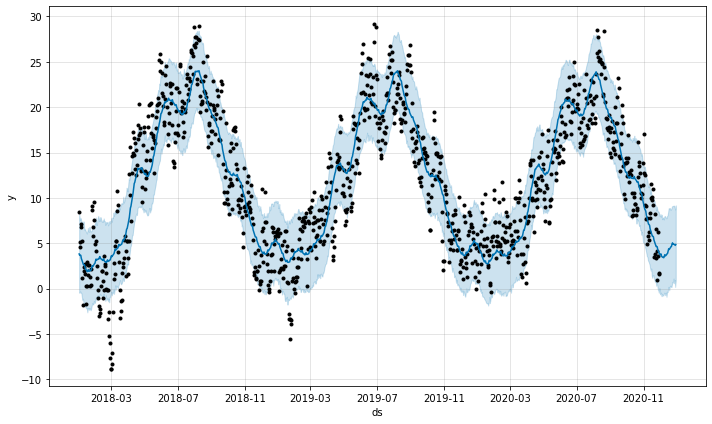

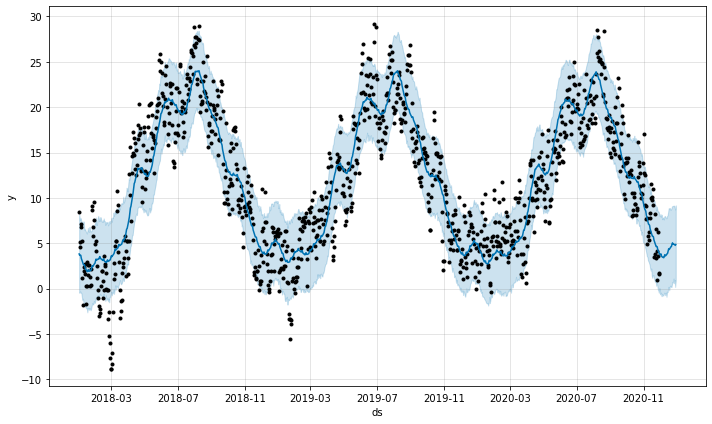

In [59]:
model = Prophet()
model.fit(data)
future = model.make_future_dataframe(periods=30) 
prediction = model.predict(future)
model.plot(prediction)

/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


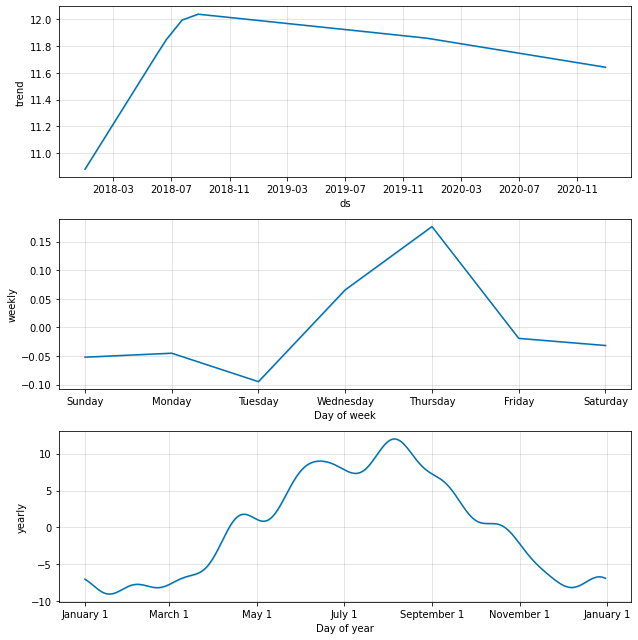

In [60]:
model.plot_components(prediction)
plt.show()

In [61]:
start_test= end_date
end_test= "2022-05-28"

In [62]:
df_testout = get_the_daily_data(start_test, end_test)[:30]

INFO:wetterdienst.core.scalar.request:Processing request DwdObservationRequest(parameter=[(kl/kl)], resolution=daily, period=[None], start_date=2020-11-30 00:00:00+00:00, end_date=2022-05-28 00:00:00+00:00, humanize=True, tidy=False, si_units=True)
INFO:wetterdienst.core.scalar.request:Filtering for station_id=['00433']
INFO:wetterdienst.core.scalar.values:0%|          | 0/1 [00:00<?, ?it/s]
INFO:wetterdienst.provider.dwd.observation.api:Acquiring observations data for kl/daily/historical/00433.
INFO:wetterdienst.provider.dwd.observation.api:Acquiring observations data for kl/daily/recent/00433.
INFO:wetterdienst.core.scalar.values:100%|##########| 1/1 [00:00<00:00,  2.55it/s]


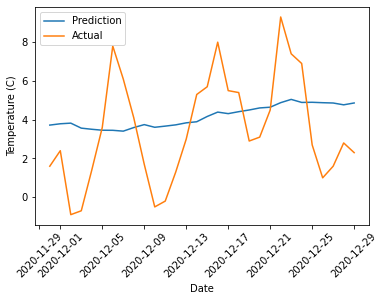

In [63]:
df_eva = evaluate_prophet(df_testout, start_test, prediction)

In [64]:
df_eva.to_csv('predict_simple.csv')

## Play around with the parameters

In [65]:
model_better = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  holidays=None,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=0,
                  changepoint_prior_scale=0.01,
                  mcmc_samples=0
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=100,
                                    prior_scale=10,
                                    mode='multiplicative').add_seasonality(name='monthly', period=30.5, fourier_order=10)

In [66]:
model_better.fit(data)

/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -73.5452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1919.13   1.63993e-06       476.714       0.883       0.883      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1919.13   9.68028e-09       471.996      0.2242      0.2242      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [67]:
future_today = model_better.make_future_dataframe(periods=30) 
prediction_today = model_better.predict(future_today)
#m.plot(prediction)

/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/envs/wetter/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [68]:
prediction_today

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2018-01-01,12.391733,0.966753,8.375767,12.391733,12.391733,-0.092006,-0.092006,-0.092006,-0.619320,-0.619320,-0.619320,-0.527314,-0.527314,-0.527314,0.0,0.0,0.0,4.717285
1,2018-01-02,12.390691,-0.196359,7.114799,12.390691,12.390691,-0.042655,-0.042655,-0.042655,-0.712246,-0.712246,-0.712246,-0.669591,-0.669591,-0.669591,0.0,0.0,0.0,3.565471
2,2018-01-03,12.389649,-0.348275,7.303842,12.389649,12.389649,-0.013319,-0.013319,-0.013319,-0.721235,-0.721235,-0.721235,-0.707916,-0.707916,-0.707916,0.0,0.0,0.0,3.453804
3,2018-01-04,12.388607,0.993645,8.606500,12.388607,12.388607,0.002453,0.002453,0.002453,-0.606324,-0.606324,-0.606324,-0.608777,-0.608777,-0.608777,0.0,0.0,0.0,4.877103
4,2018-01-05,12.387566,2.583019,9.449070,12.387566,12.387566,0.041695,0.041695,0.041695,-0.544952,-0.544952,-0.544952,-0.586647,-0.586647,-0.586647,0.0,0.0,0.0,5.636939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2020-12-26,11.256142,0.333454,8.291644,11.256142,11.256142,-0.037836,-0.037836,-0.037836,-0.617765,-0.617765,-0.617765,-0.579930,-0.579930,-0.579930,0.0,0.0,0.0,4.302486
1091,2020-12-27,11.255100,-0.062619,7.773006,11.255100,11.255100,-0.010832,-0.010832,-0.010832,-0.654482,-0.654482,-0.654482,-0.643650,-0.643650,-0.643650,0.0,0.0,0.0,3.888836
1092,2020-12-28,11.254058,-0.661713,7.024107,11.254058,11.254058,-0.046288,-0.046288,-0.046288,-0.732931,-0.732931,-0.732931,-0.686643,-0.686643,-0.686643,0.0,0.0,0.0,3.005611
1093,2020-12-29,11.253016,-0.706467,7.093707,11.253016,11.253016,-0.044819,-0.044819,-0.044819,-0.702452,-0.702452,-0.702452,-0.657633,-0.657633,-0.657633,0.0,0.0,0.0,3.348308


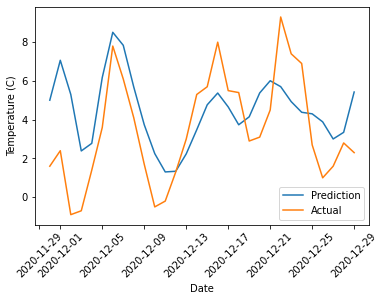

In [69]:
df_better = evaluate_prophet(df_testout, start_test, prediction_today)